<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Bias-Variance Tradeoff
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning 2021</b> <br>
    <b>Lab01.03 - 17/03/2021<br>
    Marco Cannici <br>
    <a href="mailto:marco.cannici@polimi.it">marco.cannici@polimi.it</a><br>
    </div>
    </td>
    <td width="100px"> 
        <a href="http://chrome.ws.dei.polimi.it/index.php?title=Machine_Learning_Bio">
        <img align="right", width="100px" src='https://chart.googleapis.com/chart?cht=qr&chl=chrome.ws.dei.polimi.it/index.php?title=Machine_Learning_Bio&chs=180x180&choe=UTF-8&chld=L|0' alt=''>
        </a>
    </td>
</tr>
</table>

Given a dataset and a parametric function to optimize, there are usually many different ML approaches that one can take to optimally solve the problem. However, in many cases, the most powerful model may not be the best solution for the task at hand. Choosing the right model to use and having a metric to measure the performance of a trained model are two key concepts in machine learning. 

In this notebook we will use a simple example to show some a fundamental problem in machine learning that relates to model complexity and data availability: the **bias-variance tradeoff**.

## Statistical Learning - Recap (Regression)

When performing regression analysis we would like to model the relationship between a continuous variable $f(x) \in \mathbb{R}$ and some input variables $x_1, x_2, .., x_p \in \mathbb{R}$. In general, however, **we are not able to measure the true relationship between $x$ and $f(x)$** since:
- we can only measure the response of the system through a noisy observation (e.g., a sensor providing inconsistent readings)
- we are not able to exactly model all the phenomena (e.g., input variables) that may influence the system response (e.g., an earthwake monitor device may detect a train passing in nearby subway and generate noisy readings because of that; we cannot model a real environment perfectly)

In general, we model this uncertanty in our observations as an additive random noise $\epsilon$: $y = f(\mathbf{x}) + \epsilon$

where $\mathbf{x} \in \mathbb{R}^p$ is a vector collecting all input variables, $y \in \mathbb{R}$ is the observation, and $\epsilon$ is usually distributed as $\mathcal{N}(0, 1)$.

### Fitting a regression model

Given a set of $N$ observations $(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), ..., (\mathbf{x}_N, y_N)$ we want to fit a model $\hat{y_i} = \hat{f}(\mathbf{x}_i)$ in such a way that the model prediction is as close as possible to the observed response $y_i$. That is, given an **error meause** $E$, we want to find the  parameters of the model that minimize $E(y_i, \hat{y}_i)$ $\forall i = 1,...,N$

For regression models we usually measure the model performance in terms of the mean squared error $MSE(\mathbf{y}, \mathbf{\hat{y}}) = \frac{1}{N} \sum_{i=1}^N{(y_i - \hat{y}_i)^2}$

### Training and test

In order to measure the *true* performance of the model, we usually split the set of available data into the **training** and **test** sets. We use the first to tune the model parameters while the second one to measure its performance on data that has never seen during training.

We distinguish between **training error**, the error computed on training data, and **test error**, the one computed on the leave-out set. 

### Reducible and irreducible error

When training a model we have to remember that the performance of the model depends on two quantities, which we usually call **reducible** and **irreducible** errors. Since we can only observe the system through noisy observations, even the perfect model $\hat{f}$, that has been trained on infinitely many training data and it is able to perfectly predict them, will have an error on a test set. The additive noise $\epsilon$ is indeed independent from the set of variables $\mathbf{x}$ we can observe and we have no way to minimize it. We call this error **irriducible** error, while the remaining part of the error (that depends on observable variables) the **reducible error**

$\mathbb{E}(y-\hat{y})^{2} =\mathbb{E}[f(\mathbf{x})+\epsilon-\hat{f}(\mathbf{x})]^{2}
=\underbrace{[f(\mathbf{x})-\hat{f}(\mathbf{x})]^{2}}_{\text {Reducible }}+\underbrace{\operatorname{Var}(\epsilon)}_{\text {Irreducible }}$

## Example

In [30]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

Let's assume that 
- there exists an **unknown** relationship $f(x) = 2 \cdot sin(1.5 \cdot x)$ between an observed variable $x$ and an output $y$
-  we are given $N$ (noisy) observation of such relationship $y = f(x) + \epsilon$ with $\epsilon \sim \mathcal{N}(0,1)$

We want to fit a **regression model** (with a tunable complexity **degree**) to predict the output value $y$ given an obseration point $x$

### Dataset creation

In [31]:
def sample_f(nsamples, minx=0.0, maxx=4.5):
    """
    Return 'nsamples' samples without noise with x ranging
    within the interval ['minx', 'maxx']
    
    Arguments:
        nsamples (int): the number of samples to generate
        minx (float): the minimum x value
        maxx (float): the maximum x value
    """
    # Generate 'nsampels' equally spaced points
    # between the [minx, maxx] range
    # x.shape = [nsamples]
    x = np.linspace(minx, maxx, nsamples)
    y = 2 * np.sin(1.5 * x)
    return x, y

sample_f(10)

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 array([ 0.        ,  1.36327752,  1.99498997,  1.55614639,  0.28224002,
        -1.14312264, -1.95506024, -1.71786899, -0.558831  ,  0.90008815]))

In [32]:
def sample_noise(nsamples, mu=0.0, var=1.0):
    """
    Generate additive noise distributed as a Gaussian with mean 'mu'
    and variance 'var'
    
    Arguments:
        nsamples (int): the number of error values to generate
        mu (float): the mean of the Gaussian distribution
        var (float): the variance of the Gaussian distribution
    """
    # Generate a noise value for each point 
    e = np.random.normal(mu, var, nsamples)
    return e

In [33]:
def preprocess(x, y):
    """
    Preprocess the data so that we can use sklearn models
    """
    
    # We sort the points in increasing order of x so that
    # using plt.plot() will result in a smooth function
    
    # WARNING: We do this operation here for convenience,
    # and since the fitting procedure we will use does not 
    # depend on the sample order. However this is not always 
    # the case and some training procedure may benefit from 
    # random order!
    idx_sorted = np.argsort(x)
    x, y = x[idx_sorted], y[idx_sorted]
    
    # We add a dimension since sklearn wants [N, 1] input
    # arrays, rather than [N] arrays
    x = np.expand_dims(x, -1)
    y = np.expand_dims(y, -1)

    return x, y

In [34]:
nsamples = 30
np.random.seed(42)

# Training dataset
# ================
# x.shape = [nsamples], f.shape = [nsamples]
x, f = sample_f(nsamples)
# We sample a noise value for each data point
# in the training set, e.shape = [nsamples]
e = sample_noise(nsamples)

# our obserrvation
y = f + e 

### Train / Test data splitting

In [35]:
test_perc = 0.2
np.random.seed(42)

# Split training and test
# =======================
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_perc)

print(x.shape)

x_train.shape, x_test.shape

(30,)


((24,), (6,))

In [36]:


# Preprocess data
# ===============
# The library we use needs the input arrays to be
# of shape [n_samples, n_features] while our arrays
# are now of shape [n_samples]
x_train, y_train = preprocess(x_train, y_train)
x_test, y_test = preprocess(x_test, y_test)


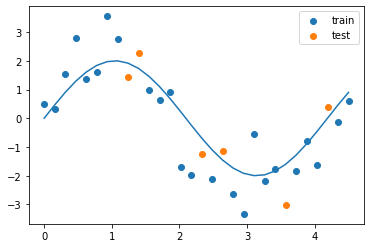

In [37]:

# Plot the data
# =============
# Plot points with different colors based on the set
plt.scatter(x_train, y_train, label='train')

plt.scatter(x_test, y_test, label='test')

plt.legend()

# Plot the true function f using a lot of points 
# (>> nsamples) in order to have a smooth function

plt.plot(x, f)

### Fit the model

We use the python package **scikit-learn** to fit a Linear model (with polynomial features of a certain degree). Since we still don't know how the model works and how it's trained (but you will soon!), in this notebook we will treat the model as a **black-box** function.

Play with the degree parameter to see how the model complexity changes as the degree parameter increases.

In [38]:
def fit_model(x, y, degree):
    """
    Fit a polynomial model to the input data.
    
    Arguments:
        x (np.ndarray): the input set of features as a numpy
            array of shape [N]
        y (np.ndarray): the target values as a numpy array
            of shape [N]
        degree (int): the polynomial degree
            
    Returns:
        A polynomial model trained on the given training set
    """
    
    model = Pipeline([('poly_features', 
                       PolynomialFeatures(degree=degree)), 
                      ('linear_regression', 
                       LinearRegression())])
    model.fit(x, y)
    return model
    

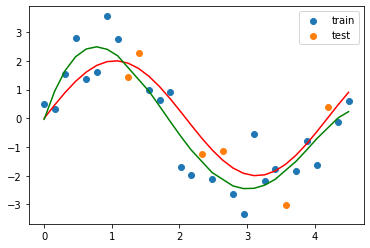

In [39]:
# Model fitting
# =============
degree = 5
# Fit the model (on the training set!!!)
linear = fit_model(x_train, y_train, degree)
# Evaluate the model on the same training data
# to obtain the learnt function
y_hat = linear.predict(x_train)

# First plot the data points
plt.scatter(x_train, y_train, label='train')
plt.scatter(x_test, y_test, label='test')
plt.legend()
# Then the prediction surface
plt.plot(x, f, color='red')
plt.plot(x_train, y_hat, color='green')


### Model performance

We measure the model performance using the mean squared error $MSE(\mathbf{y}, \mathbf{\hat{y}}) = \frac{1}{N} \sum_{i=1}^N{(y_i - \hat{y}_i)^2}$

In [40]:
def compute_mse(y, y_hat):
    """
    Computes the MLE between a target y and a predicted value y_hat
    Note: this also equivalent to sklearn.metrics.mean_squared_error
    
    Arguments:
        y (np.ndarray): An array containing target values for each data point
        y_hat (np.ndarray): An array containing predicted values for each data point
    """
    return np.mean((y - y_hat) ** 2)

In [41]:
y_hat_train = linear.predict(x_train)
train_error = compute_mse(y_train, y_hat_train)

y_hat_test = linear.predict(x_test)
test_error = compute_mse(y_test, y_hat_test)

print("Training error: {}".format(train_error))
print("Test error: {}".format(test_error))
# from sklearn.metrics import mean_squared_error
# print(mean_squared_error(y, y_hat))

Training error: 0.5635729718415076
Test error: 0.6504859729410812


### Model complexity as a function of degree

Due to the presence of noise and to the limited number of data points, fitting the most powerful model may not be the right choice, especially if the true (but unknown) reationship describing the data is simple, as in our case. By using a complex model we may indeed start "to learn the noise in the data", i.e., try to extract a relationship between $x$ and the noise that doesn't actually exist. 

We can visualize this behaviour by plotting the learnt models as a function of the model complexity (i.e., the polynomial degree in our case). As the degree increases (from light to intense colors) the model transitions from smooth functions to noisy functions that almost perfectly model the data (including noise!). Since the model gets more and more powerful, it starts to "learn" the training dataset we are using, rather than learning the general relationship between input and output values. This behaviour is usualy called **overfitting**.

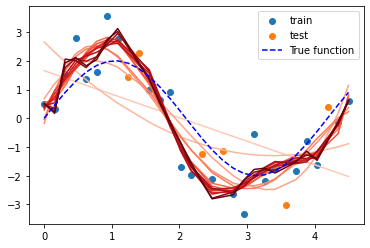

In [42]:
degrees = range(1, 15)

# First plot the data points
plt.scatter(x_train, y_train, label="train")
plt.scatter(x_test, y_test, label="test")

# Setup colors 
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(0.2,1, len(degrees)))
plt.gca().set_prop_cycle(cycler('color', colors))

# Cycle through all degrees and train a model for
# each degree. Then also keep track of all the
# trained models within a list 'trained_models'
trained_models = []
for degree in degrees:
    # Fit the model with a specific degree
    model = fit_model(x_train, y_train, degree)
    trained_models.append(model)
    # Compute train predictions
    y_hat_train = model.predict(x_train)
    # Then plot the prediction surface
    plt.plot(x_train, y_hat_train)

# Plot the true function
plt.plot(x, f, "b--", label="True function")
plt.legend()



### Train and Test error as a function of degree

By looking at the previous graphs, we expect two behaviours:
- The **training error** (computed on training, blue, points) will **decrease** as the model complexity increases, since intense colored lines are more close to training points
- The **test error** will initially decrease (very simple models are too simple) and then eventually start to increase

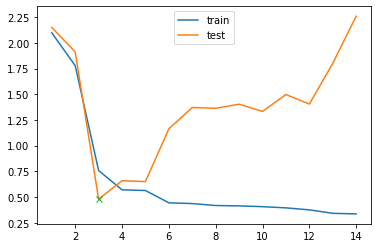

In [43]:
# Compute train and test performance
# as a function of the model degree

train_errors = []
test_errors = []
for model in trained_models:
    y_hat_train = model.predict(x_train)
    train_errors.append(compute_mse(y_train, y_hat_train))
    
    y_hat_test = model.predict(x_test)
    test_errors.append(compute_mse(y_test, y_hat_test))
    
min_idx = np.argmin(test_errors)
min_test_deg = degrees[min_idx]
min_test_err = test_errors[min_idx]

plt.plot(degrees, train_errors, label="train")
plt.plot(degrees, test_errors, label="test")
plt.plot(min_test_deg, min_test_err, "x")
plt.legend()

When training a model we always search for a good compromise between model complexity and accuracy.

Degree $3$ in this case is the best compromise since it provides the best performance on a set of never seen samples.

## Bias-Variance tradeoff - Recap

This is a problem we have to face while training any machine learning model and it is closely related to the presence of *noise in the data* and the most often very *scarce availability of training pairs*. 

Most importantly, the U-shape of the test MSE curve turns out to be the result of *two competing properties of statistical learning methods*, i.e., the **bias** and **variance**, which are both related to the concept of *hypothesis space*.

### Hypothesis space

When we make the choice to solve a statistical problem using a specific class of models (e.g., polynomial functions of a specific fixed degree), we are effectively limiting the search space of the best model to a specific class of functions. We call the space of functions that can be represented by our model the **hypothesis space** $\mathcal{H}$.

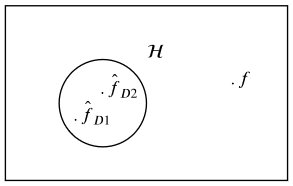

Lets assume we have datasets with some features, Rectangle represent the space of all possible functions. The space in the circle (Hypothesis space) are related to the parameter that we states in term of degree/complexity/polinomial of our model. 

$\hat{f}_{D_1}$ and $\hat{f}_{D_2}$ are the same degree, but we fit on different data set.

In our example, if we fix the polynomial degree to 1, we are effectively considering the *hypothesis space of lines*  and, by fitting the model, we are searching for the best line describing the data. The hypothesis space of lines will intuitively be quite **small** and probably **very far away** from the class of functions where the true function $f$ is actually contained (the class of sinusoidal functions).

### Bias and Variance

A model $\hat{f}_{D_1}$ trained on the dataset $D_1$ is a particular point in the hypothesis space $\mathcal{H}$. In other words, given a certain choice for the class of models, no matter the size of the training set, all the models $f_{D_i}$ will be inside the hypothesis space $\mathcal{H}$.

This implies that, if we choose a class of models that is not exactly the class of models of the target function (this is often the case when we model very complex behaviors), our predictions will always be a little bit different from the actual ones, no matter how well we fit the model. This concept (related to the error we commit by choosing a particular model), is called **bias**. We can think of the bias as the distance between the true function and the expected model, obtained by averaging models in $\mathcal{H}$ trained on every possible dataset $D_i$ of a fixed size.

Intuitively, the larger the hypothesis space, the larger the type (and complexity) of functions we can represent with our model class. However, choosing a large hypothesis space is usually connected with a greater variability of predictions. Indeed, since functions can have very different shapes in a large $\mathcal{H}$, we may end up obtaining very different $\hat{f}_{D_i}$ by training the *same model* on even slightly different datasets $D_i$. The tendence of a model to produce different estimations if trained with different datasets is called **variance**.

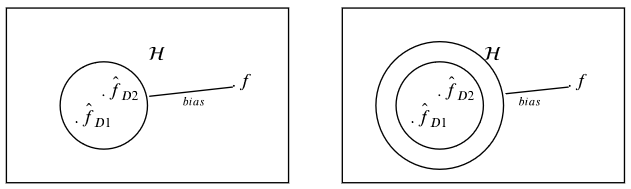

Intuitively, **the larger the $\mathcal{H}$, the more complex/flexible the model and the larger the variance (connected to the hypothesis space size) but the lower the bias (connected to the distance from the true function $f$)**

### Visualize model bias and variance 

Let's try to fit the same model (fixed degree) with different datasets (of the same size) to have a first visual understanding on the concepts of bias and variance.

*We expect simple models (low degrees) to produce functions that look all very similar and complex models (high degrees) to produce functions that have very different shapes.*

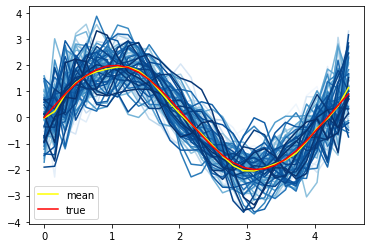

In [50]:
np.random.seed(0)

ndatasets = 100
nsamples = 30
degree = 15
var = 1.0

# Fix the true distribution
x_true, f_true = sample_f(nsamples)

cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(0,1, ndatasets))
plt.gca().set_prop_cycle(cycler('color', colors))

# For each x point, we keep track of the model response.
# Each model will have the same complexity (flexibility) but
# will be trained on a different training set that varies for
# a small error
y_sum = np.zeros([nsamples, 1])

for i in range(ndatasets):
    # Create a new dataset, i.e., add a 
    # Gaussian noise (different for each trial)
    e = sample_noise(nsamples, var=var)
    y = f_true + e

    # preprocess data
    x, y = preprocess(x_true, y)

    # Fit the model and plot the train surface
    model = fit_model(x, y, degree)

    y_hat = model.predict(x)

    plt.plot(x, y_hat)
    
    # Update the mean (we first sum all the points and then
    # divide by the number of trials to obtain the mean)
    y_sum += y_hat

y_mean = y_sum / ndatasets
                          
plt.plot(x_true, y_mean, color="yellow", label="mean")
plt.plot(x_true, f_true, color="red", label="true")
plt.legend()

By running the cell with different **degree** values we observe that:

- If we set the degree to low values (e.g., 1 to 4) we see that predicted blue functions look all very similar to each other, while they are very different if we set very high degree values (e.g., 10-15). Therefore, we expect the **variance** to be low for low degree values and high for high degrees.

- On the contrary, if we look at the mean prediction (computed by averaging predictions produced for a point by all models $\hat{y}_j = \frac{1}{M} \sum_{i=1}^{M}{\hat{f}_{D_i}(x_j)}$) we see that it is very different from the true function for small degrees (simple models) but it looks almost the same as the true function for very high degree values. Therefore, we expect the **bias** to degrease as the degree increases.

### Computing MSE bias and variance

We know that, if we use the MSE error metric to measure the model performance, we can compute the model variance and bias with the following formula:

${\Large\mathbb{E}}_{D_i}\left[\left(y_j - \hat{f}_j^{D_i}\right)\right]$ = ${\Large\mathbb{E}}_{D_i}\left[\left(f_j + \epsilon - \hat{f}_j^{D_i}\right) \right] = \underbrace{\left( f_j - {\Large\mathbb{E}}_{D_i}\left[\hat{f}_j^{D_i}\right] \right)^2}_{bias^2} + {\large Var}_{D_i}\left[\hat{f}_j^{D_i}\right] + {\large Var}[\epsilon]$ 

where the expected value is computed over models fitted on different training datasets $D_i$ all of the same size. Notice: the formula provides the expected values of the MSE for a specific data point (i.e., the prediction for a fixed $x_j$); we have to averare over all points $x_j$ to obtain a single value representing the behavior over all the input domain

In [51]:
def model_bias_variance(degree, noise_var, nsamples, ndatasets):
    """
    Compute the bias (squared) and variance for a polynomial model with a fixed degree
    
    Arguments:
        degree (int): the degree of the polynomial
        noise_var (float): the noise variance
        nsamples (int): how many samples in each dataset
        ndatasets (int): how many dataset to use to compute the expected value
    """
    # Set the seed
    np.random.seed(42)
    
    # Fix the true distribution
    x_true, f_true = sample_f(nsamples)
    
    y_hats = []
    for i in range(ndatasets):
        # Create a new dataset (different for each dataset)
        # Add a Gaussian noise with noise_var
        e = sample_noise(nsamples, var=noise_var)
        y = f_true + e
        x, y = preprocess(x_true, y)

        # fit the model
        model = fit_model(x, y, degree)
        y_hat = model.predict(x)
        y_hats.append(y_hat)
        
    # From a list of ndatasets arrays of shape [nsamples, 1],
    # to a [ndatasets, nsamples] array. So when we stack [ndatasets, nsamples, 1] become [ndatasets, nsamples] 
    y_hats = np.stack(y_hats, axis=0)[:,:,0]
    y_mean = np.mean(y_hats, axis=0)
    # Bias[y_hat_0]^2 = (f_0 - E[y_hat_0])^2
    bias2 = ((f_true - y_mean) ** 2).mean()
    # Var[y_hat_0]
    var = np.var(y_hats, axis=0).mean()
    
    return bias2, var
        

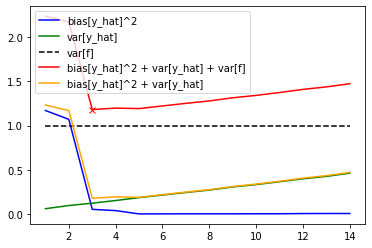

In [53]:
degrees = range(1, 15)
nsamples = 30
ndatasets = 100
noise_var = 1.0

models_bias2 = []
models_var = []

# Compute the bias^2 and variance for each choice of degree
for degree in degrees:
    bias2, var = model_bias_variance(degree, noise_var, nsamples, ndatasets)
    models_bias2.append(bias2)
    models_var.append(var)
    
noise_var = np.ones(len(degrees)) * noise_var
tot_error = np.array(models_bias2) + np.array(models_var) + noise_var
reducible_error = np.array(models_bias2) + np.array(models_var) 

# Find best tradeoff using tot_error
min_idx = np.argmin(tot_error) # index of min error of degrees
min_err_x = degrees[min_idx]
min_err_y = tot_error[min_idx]
    
plt.plot(degrees, models_bias2, "b", label="bias[y_hat]^2")
plt.plot(degrees, models_var, "g", label="var[y_hat]")
plt.plot(degrees, noise_var, "k--", label="var[f]")
plt.plot(degrees, tot_error, "r", label="bias[y_hat]^2 + var[y_hat] + var[f]")
plt.plot(degrees, reducible_error, color="orange", label="bias[y_hat]^2 + var[y_hat]")
plt.plot(min_err_x, min_err_y, "rx")

plt.legend()

As expected we see that
- the bias decreases as the complexity/flexibility increases
- the variance increases as the complexity/flexibility increases

Most importantly, we found that the best compromise for the bias/variance tradeoff is choosing a degree of $3$, which we already discovered by analyzing the MSE error on the testing set!